In [4]:
from evaluation.results import load_results
from evaluation.slurm import run_slurm
from evaluation.unit import QwenWritableConfig, DatasetID, ExperimentResult
from model_chunking import Qwen2ChunkingConfig
from matplotlib import pyplot as plt
from typing import Mapping

In [2]:
model = "Qwen/Qwen2.5-0.5B-Instruct"
experiment_names = [
    "prune_1_top", "prune_3_top",
    "prune_1_bottom", "prune_3_bottom",
    "prune_1_middle", "prune_3_middle",
    "prune_3_across", "prune_baseline"
]

prune_layers = [
    [24], [19, 21, 23],
    [3], [1, 3, 5],
    [14], [10, 12, 14],
    [7, 15, 23], []
]

configs : list[QwenWritableConfig] = []
for exp, layers in zip(experiment_names, prune_layers):
    if exp != "prune_baseline":
        config = QwenWritableConfig(
            experiment_name=exp,
            chunking_config=Qwen2ChunkingConfig.from_pretrained(
                model,
                chunking_mode="prune",
                layers_to_prune=layers,
                use_adapters=False,
                aggregation_method="mean"
            ),
            dataset=DatasetID.WIKITEXT
        )
    else:
        config = QwenWritableConfig(
            experiment_name=exp,
            chunking_config=Qwen2ChunkingConfig.from_pretrained(
                model,
                chunking_mode="uniform",
                num_layers_per_chunk=24,
                use_adapters=False,
                aggregation_method="mean"
            ),
            dataset=DatasetID.WIKITEXT
        )
    configs.append(config)

You are using a model of type qwen2 to instantiate a model of type qwen2_chunking. This is not supported for all configurations of models and can yield errors.
You are using a model of type qwen2 to instantiate a model of type qwen2_chunking. This is not supported for all configurations of models and can yield errors.
You are using a model of type qwen2 to instantiate a model of type qwen2_chunking. This is not supported for all configurations of models and can yield errors.
You are using a model of type qwen2 to instantiate a model of type qwen2_chunking. This is not supported for all configurations of models and can yield errors.
You are using a model of type qwen2 to instantiate a model of type qwen2_chunking. This is not supported for all configurations of models and can yield errors.
You are using a model of type qwen2 to instantiate a model of type qwen2_chunking. This is not supported for all configurations of models and can yield errors.
You are using a model of type qwen2 to i

In [3]:
for config in configs:
    run_slurm(config=config)

Submitted batch job 14024427
 for experiment prune_baseline


In [5]:
results : Mapping[str, ExperimentResult] = dict()
for config in configs:
    result = load_results(config=config)
    results[config.experiment_name] = result
    print(f"Experiment: {config.experiment_name}")
    print(f"\tLatency: {result.latency}s ; Perplexity: {result.perplexity}")

Experiment: prune_1_top
	Latency: 0.7136273459632798s ; Perplexity: 16787908.0
Experiment: prune_3_top
	Latency: 0.507603637770851s ; Perplexity: 57672484.0
Experiment: prune_1_bottom
	Latency: 0.6979654104402749s ; Perplexity: 17136792.0
Experiment: prune_3_bottom
	Latency: 0.49479617435153167s ; Perplexity: 33731492.0
Experiment: prune_1_middle
	Latency: 0.7575914094943811s ; Perplexity: 15033722.0
Experiment: prune_3_middle
	Latency: 0.48526094337501147s ; Perplexity: 5943206.0
Experiment: prune_3_across
	Latency: 0.5011673726657829s ; Perplexity: 94478424.0
Experiment: prune_baseline
	Latency: 0.821098777799323s ; Perplexity: 14690202.0


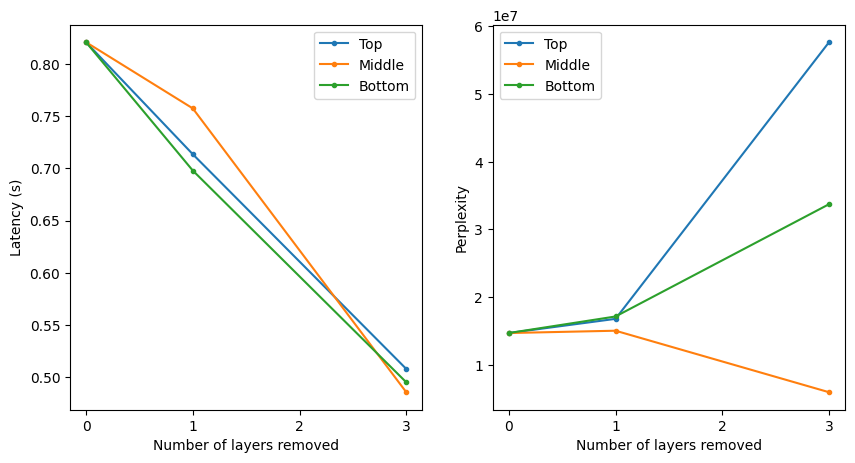

In [16]:
plt.figure(figsize=(10, 5))
num_layers_pruned = [0, 1, 3]

# PLOT 1: LATENCY VS NUMBER OF LAYERS REMOVED
plt.subplot(1, 2, 1)

top = [results['prune_baseline'].latency, results['prune_1_top'].latency, results['prune_3_top'].latency]
middle = [results['prune_baseline'].latency, results['prune_1_middle'].latency, results['prune_3_middle'].latency]
bottom = [results['prune_baseline'].latency, results['prune_1_bottom'].latency, results['prune_3_bottom'].latency]

plt.plot(num_layers_pruned, top, marker='.')
plt.plot(num_layers_pruned, middle, marker='.')
plt.plot(num_layers_pruned, bottom, marker='.')

plt.xticks([0, 1, 2, 3])
plt.xlabel("Number of layers removed")
plt.ylabel("Latency (s)")
plt.legend(['Top', 'Middle', 'Bottom'])

# PLOT 2: PERPLEXITY VS NUMBER OF LAYERS REMOVED
plt.subplot(1, 2, 2)

top = [results['prune_baseline'].perplexity, results['prune_1_top'].perplexity, results['prune_3_top'].perplexity]
middle = [results['prune_baseline'].perplexity, results['prune_1_middle'].perplexity, results['prune_3_middle'].perplexity]
bottom = [results['prune_baseline'].perplexity, results['prune_1_bottom'].perplexity, results['prune_3_bottom'].perplexity]

plt.plot(num_layers_pruned, top, marker='.')
plt.plot(num_layers_pruned, middle, marker='.')
plt.plot(num_layers_pruned, bottom, marker='.')

plt.xticks([0, 1, 2, 3])
plt.xlabel("Number of layers removed")
plt.ylabel("Perplexity")
plt.legend(['Top', 'Middle', 'Bottom'])

plt.show()